In [ ]:
# Import necessary Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as functional

from torchsummary import summary
from torch.autograd import Variable
from torchvision.utils import save_image, make_grid
from torchvision import datasets, transforms

# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=True)

# Data Loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=100, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 221523282.83it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 93253036.05it/s]


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 140219200.29it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 12492150.01it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



In [ ]:
# Variational Auto Encoder
class VAE(nn.Module):
    def __init__(self, x, h1, h2, z):
        super(VAE, self).__init__()
        
        # Encoder
        self.fc1 = nn.Linear(x, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.fc31 = nn.Linear(h2, z)
        self.fc32 = nn.Linear(h2, z)

        # Decoder
        self.fc4 = nn.Linear(z, h2)
        self.fc5 = nn.Linear(h2, h1)
        self.fc6 = nn.Linear(h1, x)
        
    def encoder(self, x):
        h = functional.relu(self.fc1(x))
        h = functional.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        h = functional.relu(self.fc4(z))
        h = functional.relu(self.fc5(h))
        return functional.sigmoid(self.fc6(h)) 
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

# build model
vae = VAE(x=784, h1= 512, h2=256, z=2)

In [ ]:
summary(vae.to("cuda"), (784, 512, 256, 2), 100, "cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [100, 512]         401,920
            Linear-2                 [100, 256]         131,328
            Linear-3                   [100, 2]             514
            Linear-4                   [100, 2]             514
            Linear-5                 [100, 256]             768
            Linear-6                 [100, 512]         131,584
            Linear-7                 [100, 784]         402,192
Total params: 1,068,820
Trainable params: 1,068,820
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 78400.00
Forward/backward pass size (MB): 1.77
Params size (MB): 4.08
Estimated Total Size (MB): 78405.85
----------------------------------------------------------------


In [ ]:
optimizer = optim.Adam(vae.parameters())

# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = functional.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [ ]:
train_losses = []
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.cuda()
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = vae(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        train_losses.append(loss)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

test_losses = []
def test():
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.cuda()
            recon, mu, log_var = vae(data)
            # sum up batch loss
            testLoss = loss_function(recon, data, mu, log_var).item()
            test_loss += testLoss
            test_losses.append(testLoss)
        
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))


for epoch in range(1, 51):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 140.419805
Train Epoch: 1 [10000/60000 (17%)]	Loss: 146.557500
Train Epoch: 1 [20000/60000 (33%)]	Loss: 149.626104
Train Epoch: 1 [30000/60000 (50%)]	Loss: 146.063174
Train Epoch: 1 [40000/60000 (67%)]	Loss: 148.351416
Train Epoch: 1 [50000/60000 (83%)]	Loss: 148.475459
====> Epoch: 1 Average loss: 147.4010
====> Test set loss: 147.1971
Train Epoch: 2 [0/60000 (0%)]	Loss: 144.005293
Train Epoch: 2 [10000/60000 (17%)]	Loss: 144.223066
Train Epoch: 2 [20000/60000 (33%)]	Loss: 157.464424
Train Epoch: 2 [30000/60000 (50%)]	Loss: 146.758359
Train Epoch: 2 [40000/60000 (67%)]	Loss: 148.253965
Train Epoch: 2 [50000/60000 (83%)]	Loss: 145.605596
====> Epoch: 2 Average loss: 145.8741
====> Test set loss: 145.8128
Train Epoch: 3 [0/60000 (0%)]	Loss: 138.759824
Train Epoch: 3 [10000/60000 (17%)]	Loss: 152.366348
Train Epoch: 3 [20000/60000 (33%)]	Loss: 151.571543
Train Epoch: 3 [30000/60000 (50%)]	Loss: 147.394512
Train Epoch: 3 [40000/60000 (67%)]	Loss: 142.24

In [ ]:
trainLosses = []
for i in range(len(train_losses)):
  if (i+1) % 6 == 0:
    trainLosses.append(train_losses[i])

In [ ]:
len(test_losses)

5000

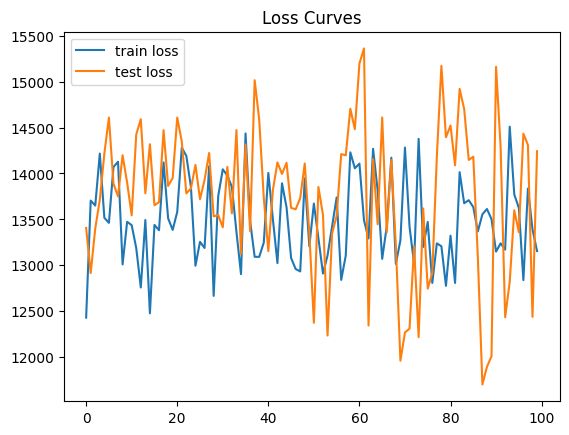

In [ ]:
plt.plot(trainLosses[len(trainLosses)-100:], label="train loss")
plt.plot(test_losses[len(test_losses)-100:], label="test loss")
plt.legend()
plt.title('Loss Curves')
plt.show()

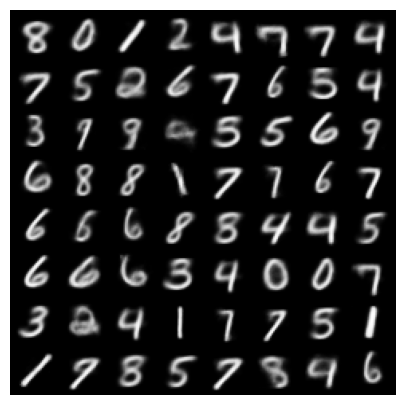

In [ ]:
with torch.no_grad():
    z = torch.randn(64, 2).cuda()
    sample = vae.decoder(z).cuda()
    # Rescale pixel values to [0, 1]
    sample = (sample - sample.min()) / (sample.max() - sample.min())
    
    # Reshape the images to 28x28 grayscale
    sample = sample.view(-1, 1, 28, 28)
    
    # Create a grid of output images
    grid = make_grid(sample, nrow=8, padding=2, normalize=False)
    
    # Display the output images
    plt.figure(figsize=(10, 5))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy().squeeze(), cmap='gray')
    plt.axis('off')
    
    plt.show()
